In [1]:
import os

import tensorflow as tf
import pandas as pd
from keras import *
from keras.layers import *
from tensorflow.lite.toco import logging

2023-05-15 13:34:54.142307: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.environ['MIOPEN_LOG_LEVEL']='4'
os.environ['ROCM_HOME']='/opt/rocm'
os.environ['ROCM_PATH']='/opt/rocm'

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-05-15 13:35:04.744264: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 13:35:06.300613: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 13:35:06.300677: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 13:35:06.307749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other oper

In [4]:
# Path to test directory
test_data_dir = "/home/voodo/PGU/mainWork/parNet/AnimalsTest/dts/test"
# Path to train directory
train_data_dir = "/home/voodo/PGU/mainWork/parNet/AnimalsTest/dts/train"

<Axes: >

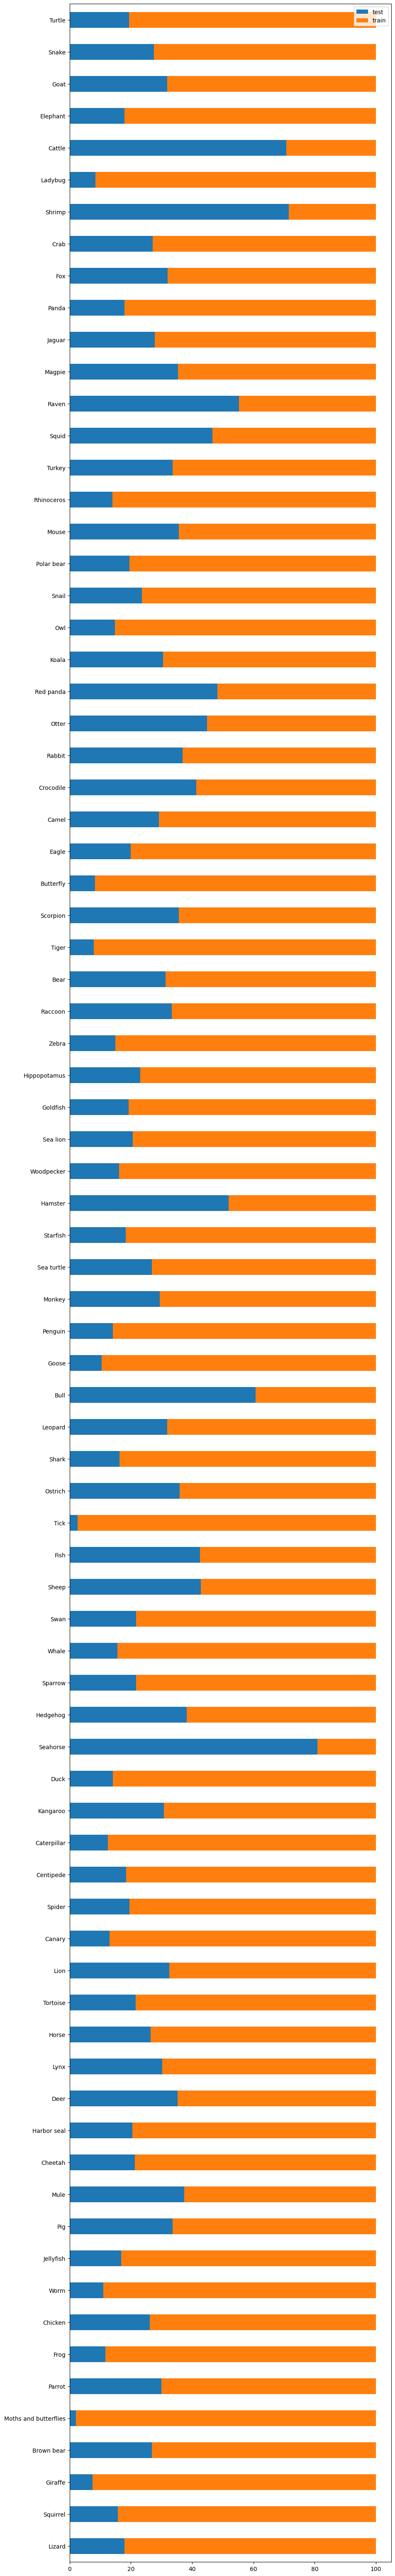

In [5]:
# Access all animal class names present for training and testing
class_names = os.listdir(train_data_dir)

animal_values = []
test_values = []
train_values = []

for name in class_names:
    test_subdirectory_path = os.path.join(test_data_dir, name)
    train_subdirectory_path = os.path.join(train_data_dir, name)
    test_image_count, train_image_count = len(os.listdir(test_subdirectory_path)), len(
        os.listdir(train_subdirectory_path)
    )
    total_image_count = train_image_count + test_image_count
    test_percent = round((test_image_count / total_image_count) * 100, 2)
    train_percent = round((train_image_count / total_image_count) * 100, 2)

    # Update the lists with appropriate values
    animal_values.append(name)
    test_values.append(test_percent)
    train_values.append(train_percent)

# Create a Pandas Dataframe
df = pd.DataFrame({"test": test_values, "train": train_values}, index=animal_values)

# Plot the data
df.plot(
    kind="barh",
    stacked=True,
    figsize=(
        10,
        80,
    ),
)

In [6]:
batch_size = 32
img_height = 180
img_width = 180

train_image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    zoom_range=0.1,
    rotation_range=0.1,
    horizontal_flip=True
)

test_image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_datagen = train_image_data_generator.flow_from_directory(
    train_data_dir,
    batch_size=batch_size,
    class_mode="binary",
    target_size=(img_height, img_width)
)

test_datagen = train_image_data_generator.flow_from_directory(
    train_data_dir,
    batch_size=batch_size,
    class_mode="binary",
    target_size=(img_height, img_width)
)

Found 22566 images belonging to 80 classes.
Found 22566 images belonging to 80 classes.


In [7]:
animals_count = len(class_names)

model = tf.keras.Sequential([
    Conv2D(16, 3, activation="relu", padding="same", input_shape=(img_width, img_height, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, activation="relu", padding="same"),
    MaxPooling2D(),
    Conv2D(64, 3, activation="relu", padding="same"),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.4),
    Dense(animals_count, name="outputs", activation="softmax"),
])

nAdam = tf.keras.optimizers.Nadam()
model.compile(
    optimizer=nAdam,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


2023-05-15 13:35:15.965785: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-15 13:35:15.978729: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-15 13:35:15.981254: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-15 13:35:15.990703: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-15 13:35:15.991345: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-15 13:35:15.992635: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-15 13:35:16.002488: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-15 13:35:16.053451: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-15 13:35:16.447416: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-15 13:35:16

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0

In [9]:
epochs = 5

history = model.fit(
    train_datagen,
    steps_per_epoch=(train_datagen.samples // batch_size),
    epochs=epochs,
    validation_data=test_datagen,
    validation_steps=(test_datagen.samples // batch_size)
)

Epoch 1/5


2023-05-15 13:35:20.049792: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-15 13:35:20.061946: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-15 13:35:20.063455: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-15 13:35:20.064637: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-15 13:35:20.065794: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-15 13:35:20.067843: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-15 13:35:20.068723: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-15 13:35:20.069088: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-15 13:35:20.175862: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-15 13:35:20

 18/705 [..............................] - ETA: 3:59 - loss: 4.3807 - accuracy: 0.0955

KeyboardInterrupt: 

In [10]:
model.save('an.h5')

2023-05-14 17:42:07.384370: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-14 17:42:07.385200: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-14 17:42:07.386709: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-14 17:42:07.387469: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-14 17:42:07.388836: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-14 17:42:07.389643: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-14 17:42:07.391286: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-14 17:42:07.449580: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-14 17:42:07.478737: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-05-14 17:42:07

<Axes: >

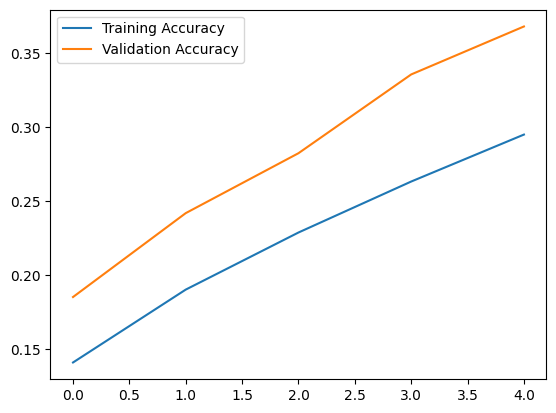

In [11]:
epochs_range = range(epochs)

training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a pd Dataframe for accuracy
acc_df = pd.DataFrame({"Training Accuracy":training_acc, "Validation Accuracy":validation_acc}, index=epochs_range)
# Create a pd Dataframe for loss
loss_df = pd.DataFrame({"Training Loss":training_loss, "Validation Loss":validation_loss}, index=epochs_range)

acc_df.plot()

AttributeError: 'Sequential' object has no attribute 'validate'